In [8]:
# ==============================================================================
# # California Car Accident Fatality Prediction (Enhanced)
#
# **Goal:** To build and enhance a machine learning model to predict the number of
# fatalities in car accidents in California.
#
# **Enhancements:**
# 1.  Advanced Feature Engineering: Added 'TIME_OF_DAY'.
# 2.  Hyperparameter Tuning: Using RandomizedSearchCV for the Random Forest.
# 3.  New Model: Implemented an XGBoost Regressor for comparison.
# ==============================================================================

# ==============================================================================
# ## Step 1: Setup and Data Loading
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Load the dataset
try:
    df = pd.read_csv('/content/combined_accident_data.csv')
    print("Dataset loaded successfully!")
    print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("Error: 'combined_accident_data.csv' not found.")
    df = None
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

Dataset loaded successfully!
The dataset has 37654 rows and 80 columns.


In [9]:
# ==============================================================================
# ## Step 2: Data Preprocessing and Filtering
# ==============================================================================
if df is not None:
    # Filter for accidents in California (State Code 6)
    df_ca = df[df['STATE'] == 6].copy()
    print(f"\nFiltered for California. The dataset now has {df_ca.shape[0]} rows.")

    # --- Feature Selection ---
    features_to_keep = [
        'FATALS', 'WEATHER', 'LGT_COND', 'HOUR', 'DAY_WEEK',
        'MAN_COLL', 'HARM_EV', 'RUR_URB', 'FUNC_SYS'
    ]
    df_model = df_ca[features_to_keep].copy()

    # --- Handling Missing Values ---
    df_model.dropna(inplace=True)
    print(f"Shape of the data after dropping rows with missing values: {df_model.shape}")


Filtered for California. The dataset now has 3727 rows.
Shape of the data after dropping rows with missing values: (3727, 9)


<ipython-input-10-1188878706>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FATALS', data=df_model, palette='viridis')


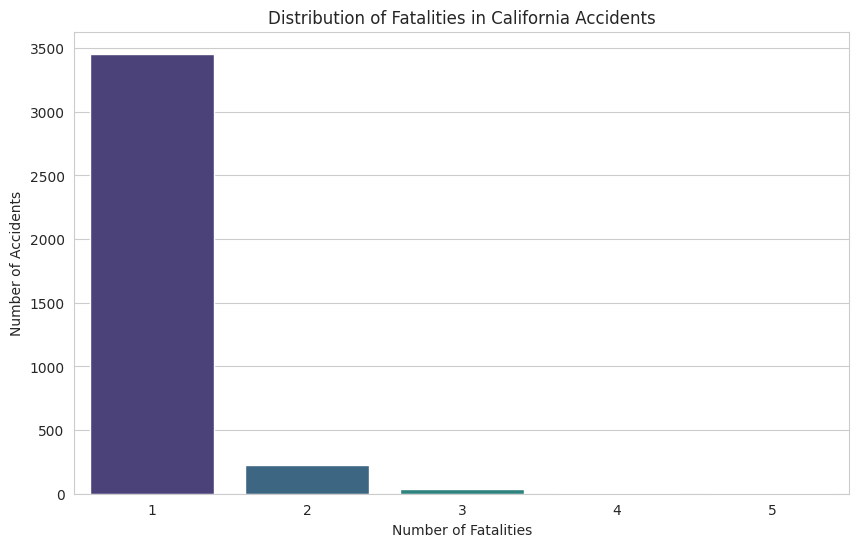

<ipython-input-10-1188878706>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DAY_WEEK', data=df_model, palette='magma')


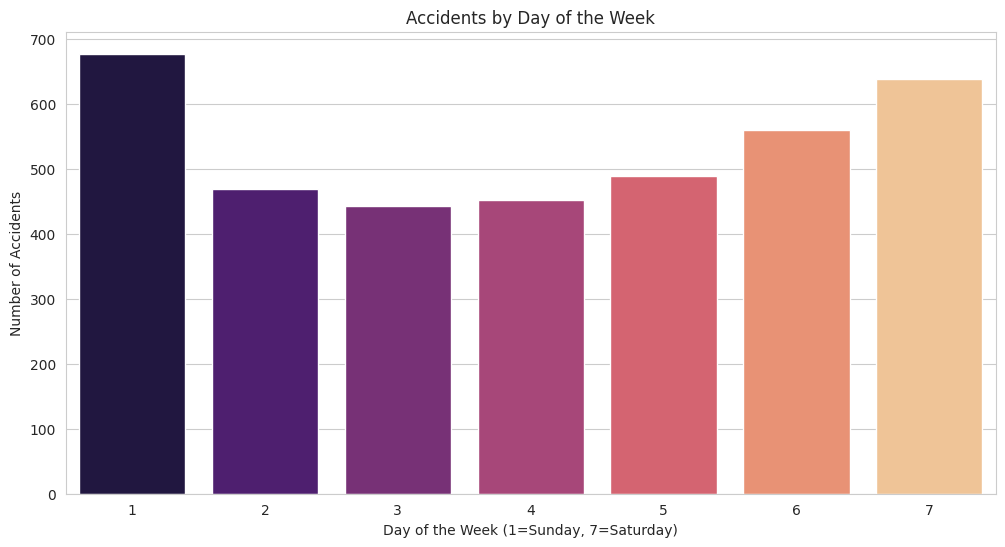

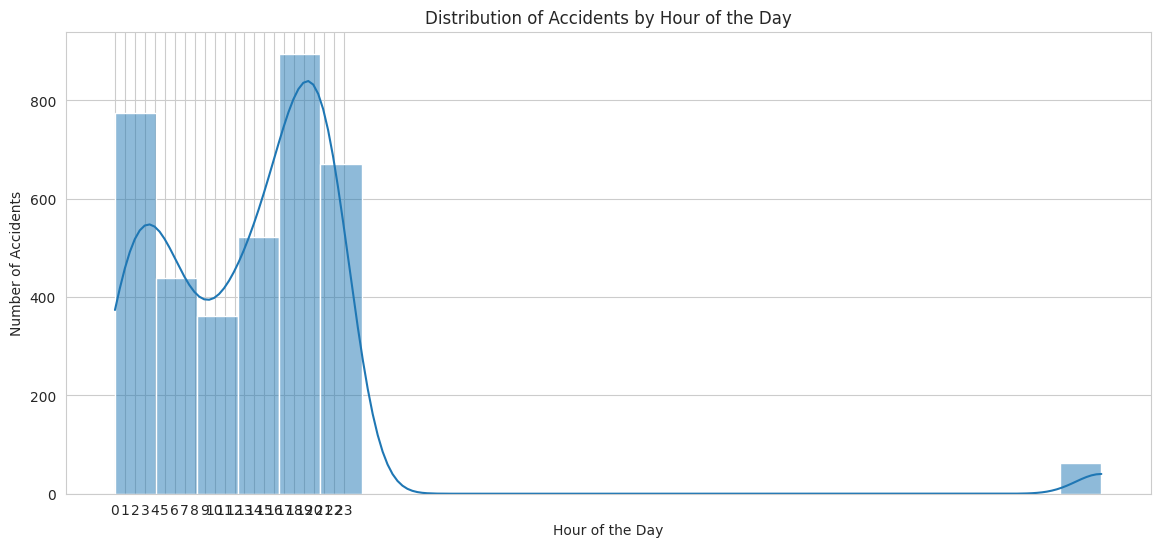

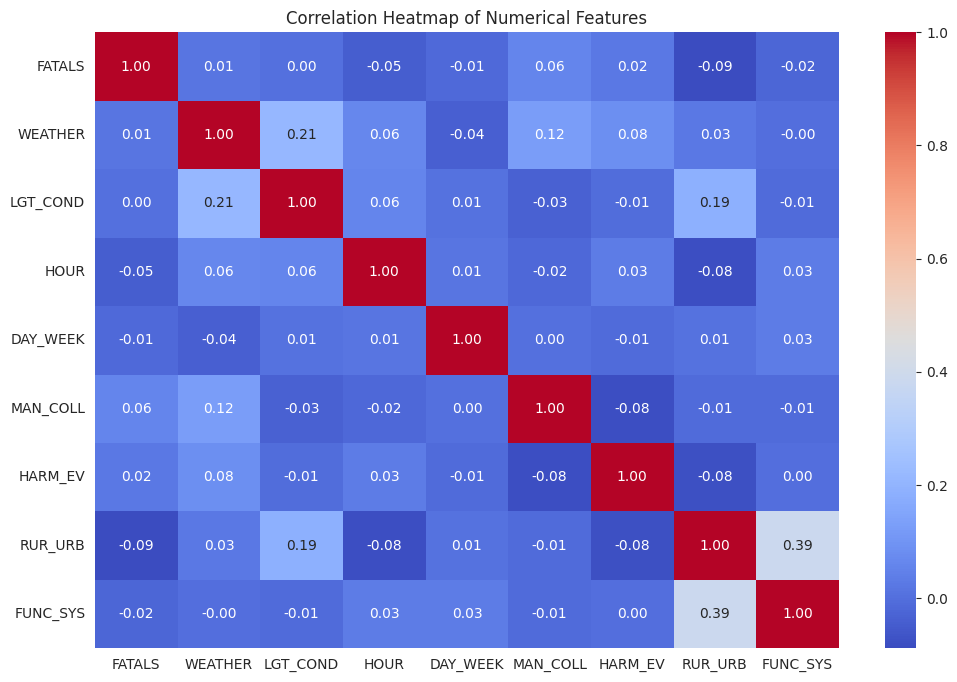

In [10]:
# ==============================================================================
# ## Step 3: Exploratory Data Analysis (EDA)
# ==============================================================================
if df is not None:
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.countplot(x='FATALS', data=df_model, palette='viridis')
    plt.title('Distribution of Fatalities in California Accidents')
    plt.xlabel('Number of Fatalities')
    plt.ylabel('Number of Accidents')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x='DAY_WEEK', data=df_model, palette='magma')
    plt.title('Accidents by Day of the Week')
    plt.xlabel('Day of the Week (1=Sunday, 7=Saturday)')
    plt.ylabel('Number of Accidents')
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.histplot(df_model['HOUR'], bins=24, kde=True)
    plt.title('Distribution of Accidents by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24))
    plt.show()

    plt.figure(figsize=(12, 8))
    corr = df_model.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

In [11]:
# ==============================================================================
# ## Step 4: Advanced Feature Engineering
# ==============================================================================
if df is not None:
    # Create a new 'TIME_OF_DAY' feature
    def get_time_of_day(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'

    df_model['TIME_OF_DAY'] = df_model['HOUR'].apply(get_time_of_day)

    # --- Encoding ---
    df_encoded = pd.get_dummies(df_model, columns=['TIME_OF_DAY'], drop_first=True)
    print("\nFeature Engineering and Encoding Complete.")


Feature Engineering and Encoding Complete.


In [12]:
# ==============================================================================
# ## Step 5: Model Building and Tuning
# ==============================================================================
if df is not None:
    # --- Data Splitting ---
    X = df_encoded.drop('FATALS', axis=1)
    y = df_encoded['FATALS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- Model 1: Random Forest Regressor (with Hyperparameter Tuning) ---
    print("\n--- Training Tuned Random Forest Regressor ---")
    rf = RandomForestRegressor(random_state=42)
    param_dist = {
        'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]
    }
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20,
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)
    print(f"Best RF Parameters: {rf_random.best_params_}")

    # --- Model 2: XGBoost Regressor ---
    print("\n--- Training XGBoost Regressor ---")
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1,
                            max_depth=5, random_state=42)
    xgbr.fit(X_train, y_train)

    # --- Save Models and Data for Evaluation ---
    models = {'Tuned_RF': rf_random.best_estimator_, 'XGBoost': xgbr}
    with open('trained_models.pkl', 'wb') as f:
        pickle.dump(models, f)
    with open('test_data.pkl', 'wb') as f:
        pickle.dump((X_test, y_test), f)
    print("\nModels and test data saved for evaluation.")


--- Training Tuned Random Forest Regressor ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}

--- Training XGBoost Regressor ---

Models and test data saved for evaluation.


In [13]:
# ==============================================================================
# # Model Evaluation and Interpretation
#
# **Goal:** To evaluate the trained models, compare their performance, and interpret
# the feature importances to understand what drives accident fatality predictions.
# ==============================================================================

# ==============================================================================
# ## Step 6: Load Models and Test Data
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

try:
    with open('/content/trained_models.pkl', 'rb') as f:
        models = pickle.load(f)
    with open('/content/test_data.pkl', 'rb') as f:
        X_test, y_test = pickle.load(f)
    print("Models and test data loaded successfully.")
except FileNotFoundError:
    print("Error: Trained models or test data not found. Please run the experimental notebook first.")
    models = None
except Exception as e:
    print(f"An error occurred: {e}")
    models = None

Models and test data loaded successfully.



--- Model Performance Comparison ---
      Model       MAE       MSE      RMSE        R2
0  Tuned_RF  0.167567  0.142943  0.378078  0.003882
1   XGBoost  0.176240  0.152729  0.390805 -0.064312


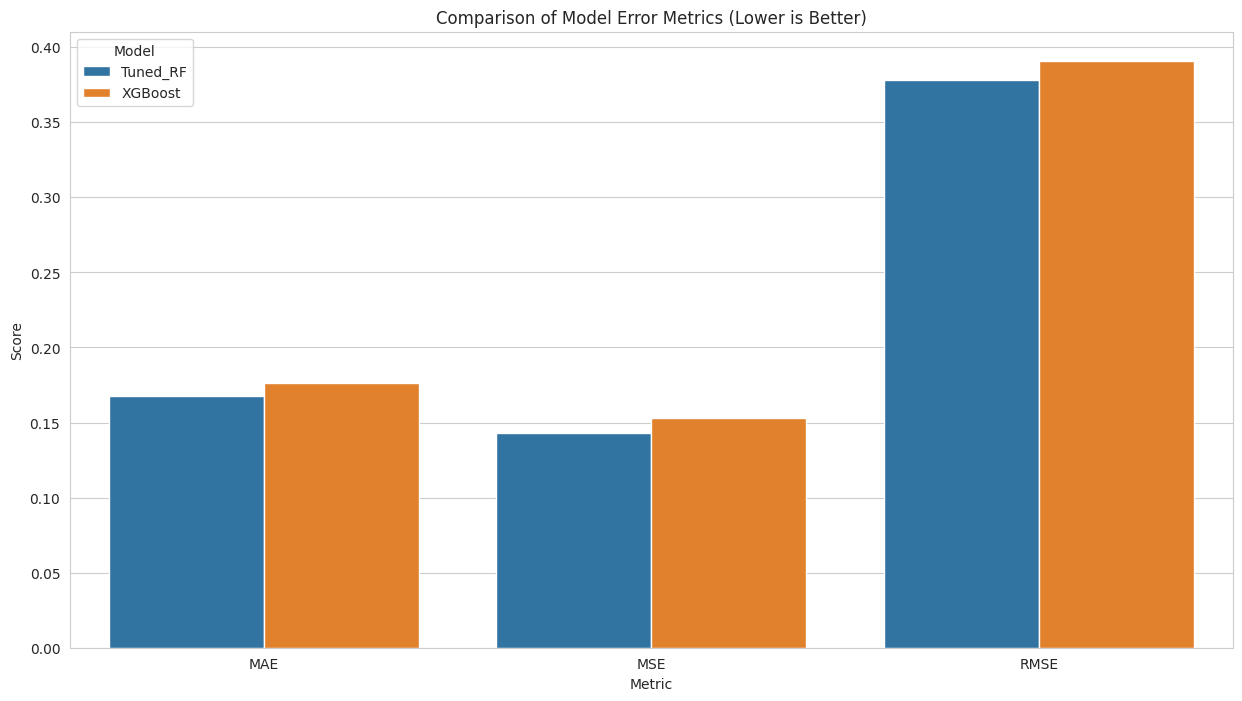

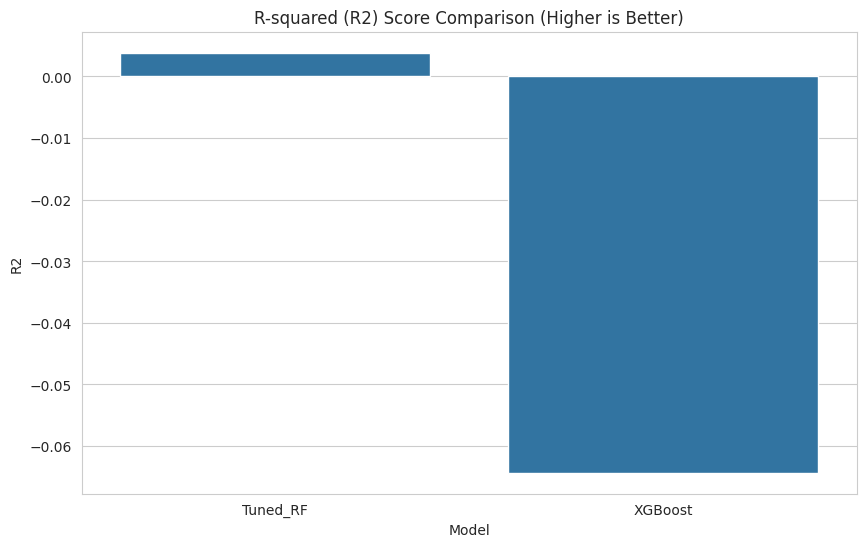

In [14]:
# ==============================================================================
# ## Step 7: Model Performance Comparison
# ==============================================================================
if models:
    results_list = []
    predictions_dict = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions_dict[name] = y_pred
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results_list.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

    results_df = pd.DataFrame(results_list)
    print("\n--- Model Performance Comparison ---")
    print(results_df)

    # --- Visualize Metrics ---
    results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted[results_melted['Metric'] != 'R2'])
    plt.title('Comparison of Model Error Metrics (Lower is Better)')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='R2', data=results_df)
    plt.title('R-squared (R2) Score Comparison (Higher is Better)')
    plt.show()

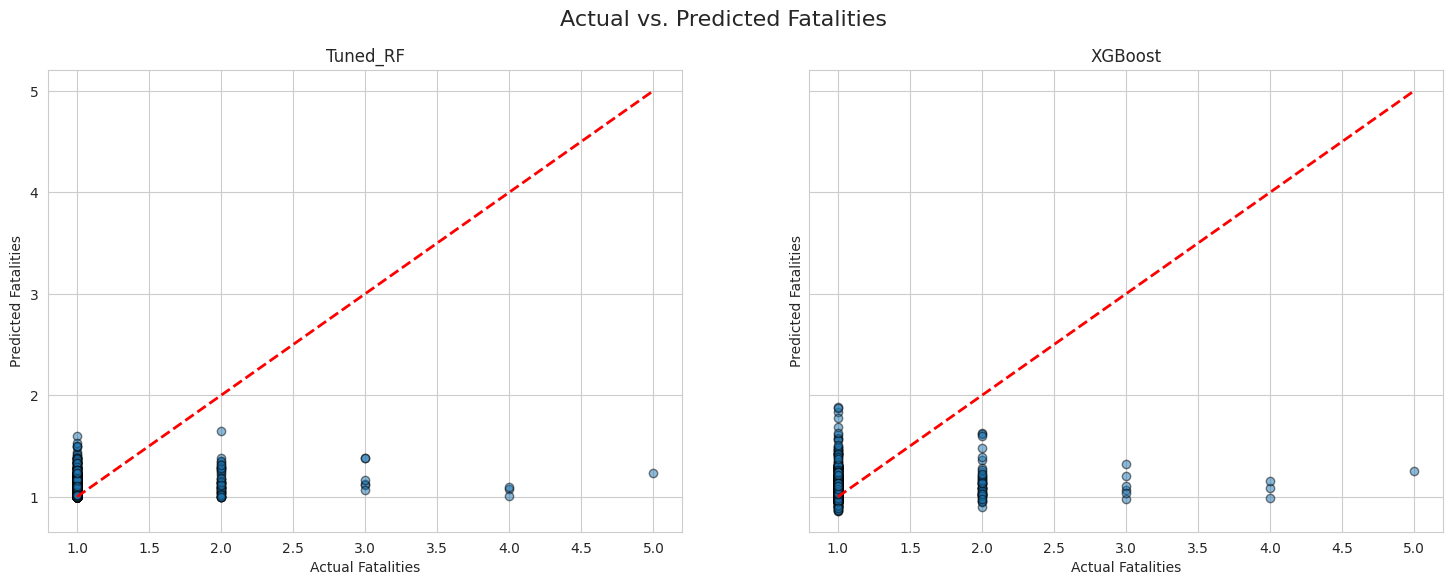

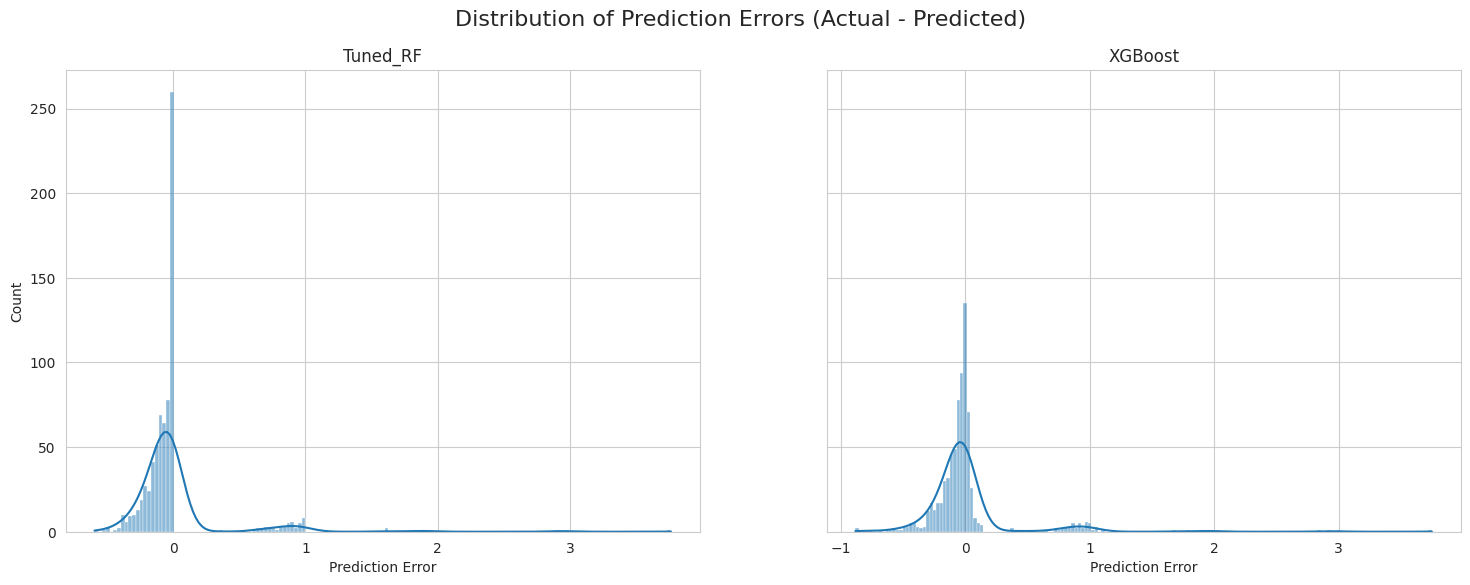

In [15]:
# ==============================================================================
# ## Step 8: Prediction and Error Analysis Visualizations
# ==============================================================================
if models:
    # --- Actual vs. Predicted Plots ---
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)
    fig.suptitle('Actual vs. Predicted Fatalities', fontsize=16)
    for i, (name, y_pred) in enumerate(predictions_dict.items()):
        ax = axes[i]
        ax.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax.set_xlabel('Actual Fatalities')
        ax.set_ylabel('Predicted Fatalities')
        ax.set_title(name)
        ax.grid(True)
    plt.show()

    # --- Error Distribution Plots ---
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)
    fig.suptitle('Distribution of Prediction Errors (Actual - Predicted)', fontsize=16)
    for i, (name, y_pred) in enumerate(predictions_dict.items()):
        ax = axes[i]
        errors = y_test - y_pred
        sns.histplot(errors, kde=True, ax=ax)
        ax.set_xlabel('Prediction Error')
        ax.set_title(name)
        ax.grid(True)
    plt.show()

<ipython-input-16-4064781392>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


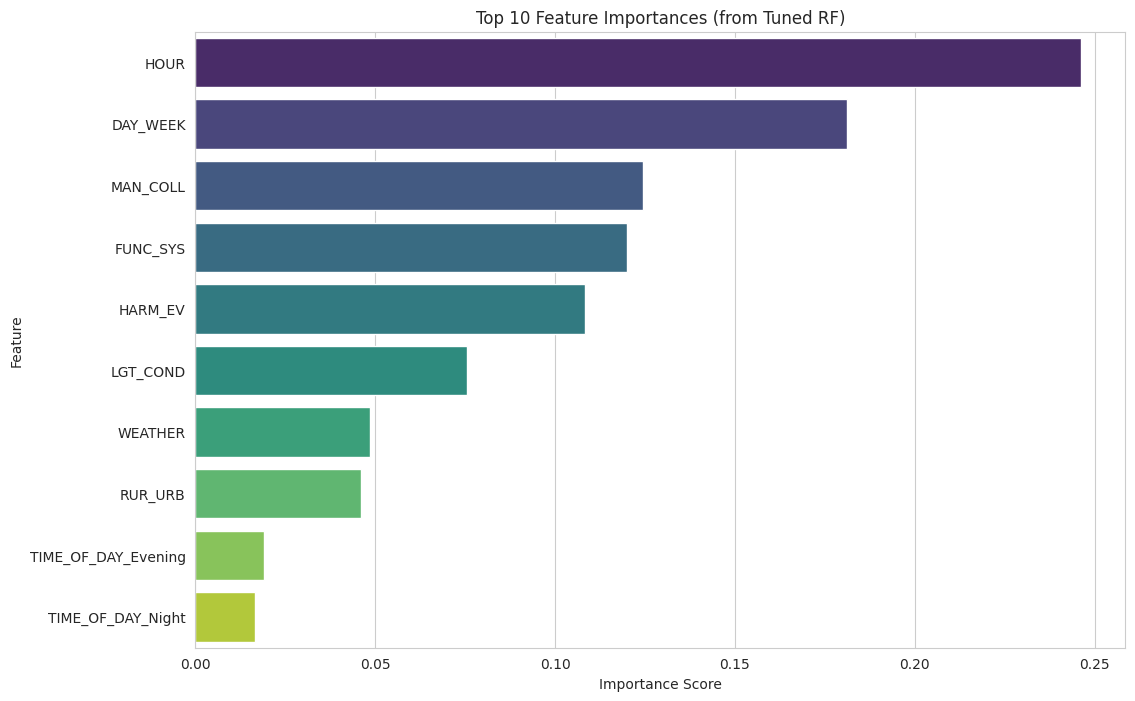

In [16]:
# ==============================================================================
# ## Step 9: Feature Importance Analysis
# ==============================================================================
if models and 'Tuned_RF' in models:
    rf_model = models['Tuned_RF']
    importances = rf_model.feature_importances_
    feature_names = X_test.columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names, 'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Feature Importances (from Tuned RF)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()